# MUSIC Super-resolution Microscopy

## Dependencies

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from PIL import Image
from mpl_toolkits.mplot3d import Axes3D

## Program Parameters

In [50]:
class params:
    k     = 2       # Source number
    M     = 8      # Sensor array size (assuming square)
    T     = 200     # Snapshot number
    noise = 0       # Noise power
    width = 1       # Sensors are placed between [-width,width]
    sep   = 0.5    # Source inter-separation distance
    sig   = 0.1       # Gaussian kernel variance
    Q     = 128      # MUSIC 'Resolution'
p = params()

## Creating Synthetic Data

$$[U]_{s,k} = u(r_s-r_k) = \exp(-\frac{1}{2\sigma}\| r_s-r_k \|^2) $$

### Plot 1D Gaussian Kernel (for viewing)

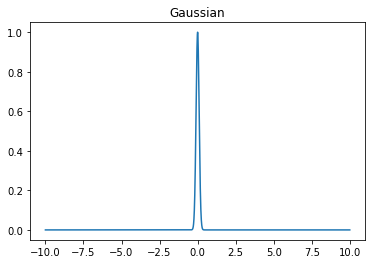

In [51]:
# Plot the 1D Kernel 
x = np.linspace(-10,10,10000)
g = np.exp(-(0.5/p.sig**2)*np.abs(x)**2)
plt.plot(x,g)
plt.title('Gaussian')
plt.show()

### Create Synthetic Measurement Data

In [52]:
# Positions
r_k = np.linspace(-p.sep*p.width,p.sep*p.width,p.k)
# Create measurement array
r_s = np.linspace(-p.width,p.width,p.M)
# From source positions, and the sensors, create the sensing matrix
U = np.exp(-(0.5/p.sig**2)*np.abs(r_s[:,np.newaxis] - r_k)**2)

# Construct random flucations over frames for the sources
x = np.random.uniform(0,2,(p.k,p.T));
# Construct additive noise (clip if less than 0)
n = p.noise*np.random.randn(p.M,p.T)
n[np.where(n < 0)] = 0

# Construct final measurements
f = U @ x + n

## Perform MUSIC to recover sources

In [53]:
def MUSIC1D(data, sensor_pos, source_num, width, sig, HR_grid_size):
    # Perform SVD on the data
    U,_,_ = np.linalg.svd(data)
    # Select columns of U which correspond to noise-subspace
    U2 = U[:,source_num:]
    # Create Grid for MUSIC
    HR_sensor_pos = np.linspace(-width,width,HR_grid_size)
    # Create HR sensing matrix
    A = np.exp(-(0.5/p.sig**2)*np.abs(sensor_pos[:,np.newaxis] - HR_sensor_pos)**2)
    # Calculate error between sensor image and projection, and invert for MUSIC result
    #err = np.linalg.norm( A - U2 @ U2.conj().T @ A, axis=0 )**2
    music = np.zeros(HR_grid_size)
    for i in range(HR_grid_size):
        err = A[:,i].T.conj() @ (U2@U2.T.conj()) @ A[:,i]
        music[i] = 1/err
    
    return HR_sensor_pos,music

music_axis, music = MUSIC1D(f,r_s,p.k,p.width,p.sig,p.Q)

## Display Results

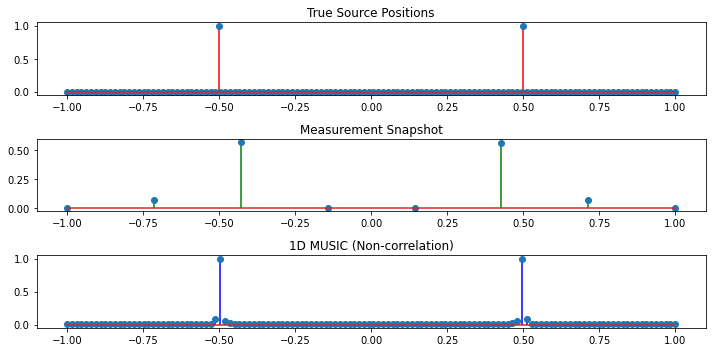

In [54]:
plt.figure(figsize=(10,5))

plt.subplot(3,1,1)
plt.stem(r_k,np.ones((p.k,1)),'r')
plt.stem(music_axis,np.zeros((p.Q,1)),'r')
plt.title('True Source Positions')

plt.subplot(3,1,2)
plt.stem(r_s,np.mean(f,axis=1)/np.max(f[:,0]),'g')
plt.title('Measurement Snapshot')

plt.subplot(3,1,3)
plt.stem(music_axis,music/np.max(music),'b')
plt.title('1D MUSIC (Non-correlation)')

plt.tight_layout()
plt.show()